<a href="https://colab.research.google.com/github/emanbuc/ultrasonic-vision/blob/main/notebooks/multiclass_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Addestramento classificatore con SciKit Learn

reference https://scikit-learn.org/stable/modules/multiclass.html


## Analisi dati

Per un'analisi più estesa dei dati vedi anche il notebook [analisi dati sensori](https://github.com/emanbuc/ultrasonic-vision/blob/main/notebooks/analisi_dati_sensori.ipynb)



     HCSR04_001  HCSR04_002  HCSR04_003  ...  HCSR04_006  HCSR04_007  ObjectClass
0         55.59       16.09       54.78  ...       57.48       96.38  BALL_CENTER
1         56.40       16.06       55.29  ...       57.42      109.68  BALL_CENTER
2         56.32       16.04       54.86  ...       58.30      116.21  BALL_CENTER
3         55.08       15.96       54.87  ...       58.28       78.56  BALL_CENTER
4         55.11       15.96       55.22  ...       57.86      111.51  BALL_CENTER
..          ...         ...         ...  ...         ...         ...          ...
302       53.43       55.59       55.07  ...       51.77      109.41    WALL_BALL
303       53.40       55.57       55.13  ...       52.60      107.89    WALL_BALL
304       53.83       55.60       55.14  ...       51.70      111.39    WALL_BALL
305       53.40       55.97       55.08  ...       51.74      109.09    WALL_BALL
306       53.41       55.63       54.76  ...       52.51      108.74    WALL_BALL

[307 rows x 8 c

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  if __name__ == '__main__':


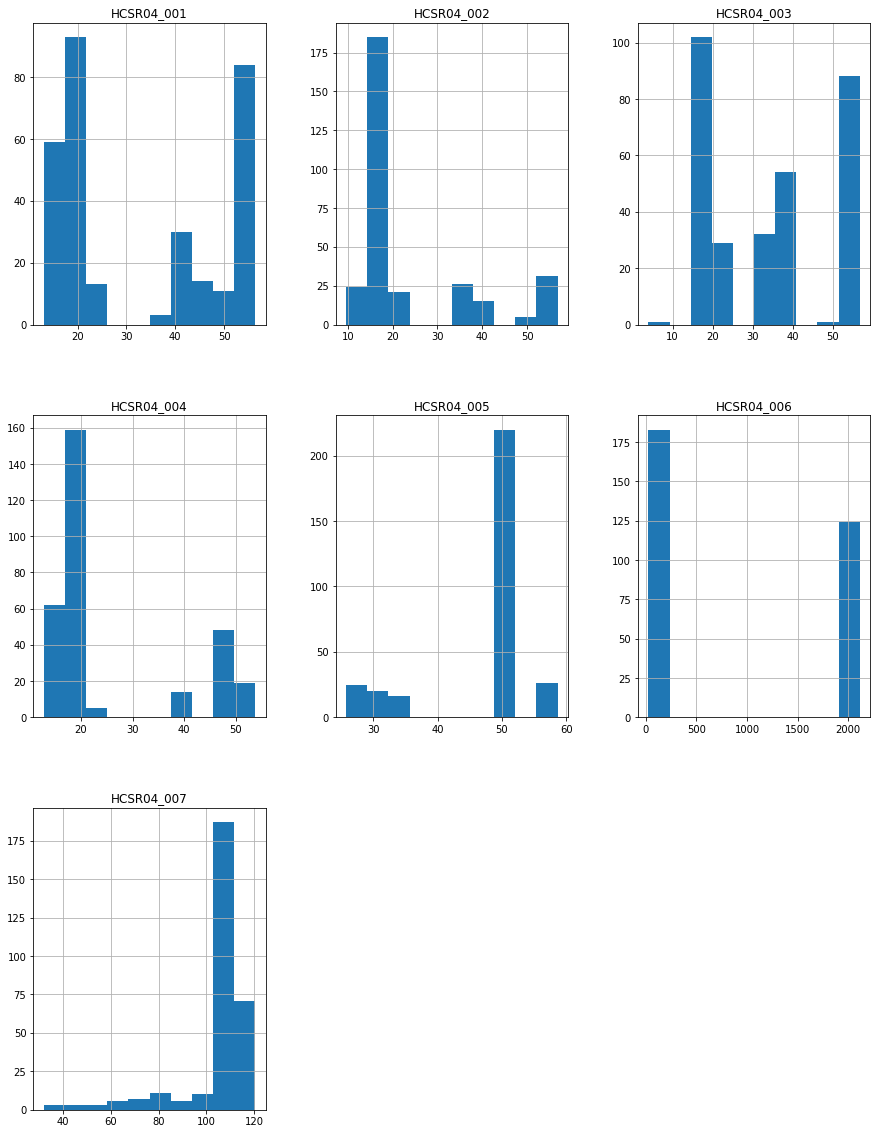

In [158]:

url = "https://raw.githubusercontent.com/emanbuc/ultrasonic-vision/main/dataset/20210102_alldata_outlier_removed.csv"
names = ['HCSR04_001', 'HCSR04_002', 'HCSR04_003', 'HCSR04_004', 'HCSR04_005', 'HCSR04_006', 'HCSR04_007',"ObjectClass"]
data = pandas.read_csv(url, usecols=names)

print(data)
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.iloc[:,0:7].hist(ax = ax)
plt.show()

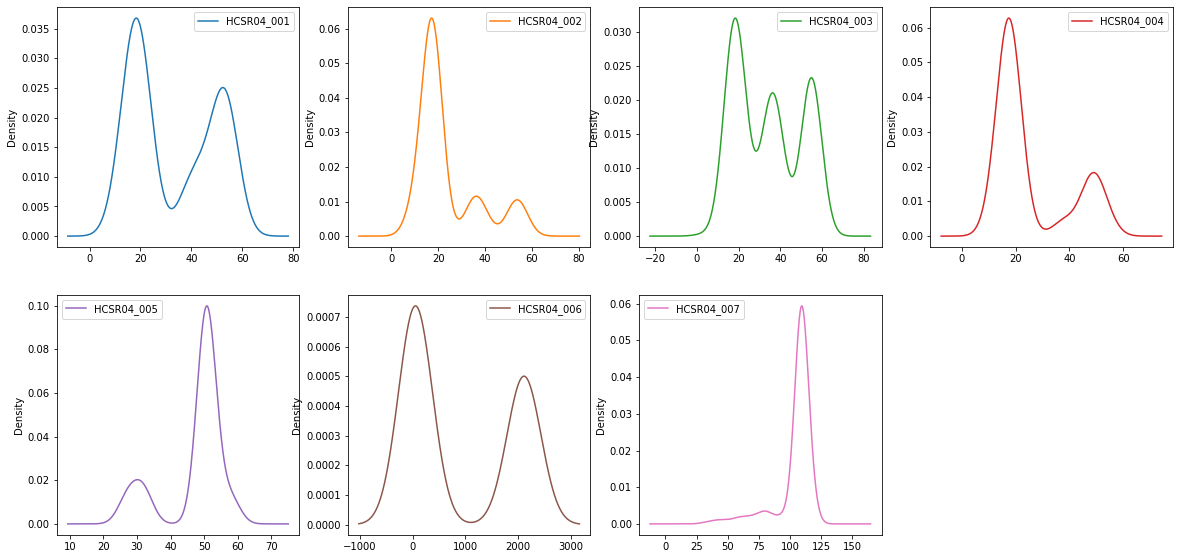

In [159]:
data.plot(kind='density', subplots=True, layout=(3,4), sharex=False, figsize=(20,15))
plt.show()

Il range delle distanze stimate dai sensori HCSR04_007 e HCSR04_006 sono molto supeiore ai valori attesi. L'analisi dei dati provenienti da questi sensori è stata approfondita dei paragrafi che seguono.

## Analisi dati HCSR04-007

Distribuzione dei dati nei diversi esperimenti

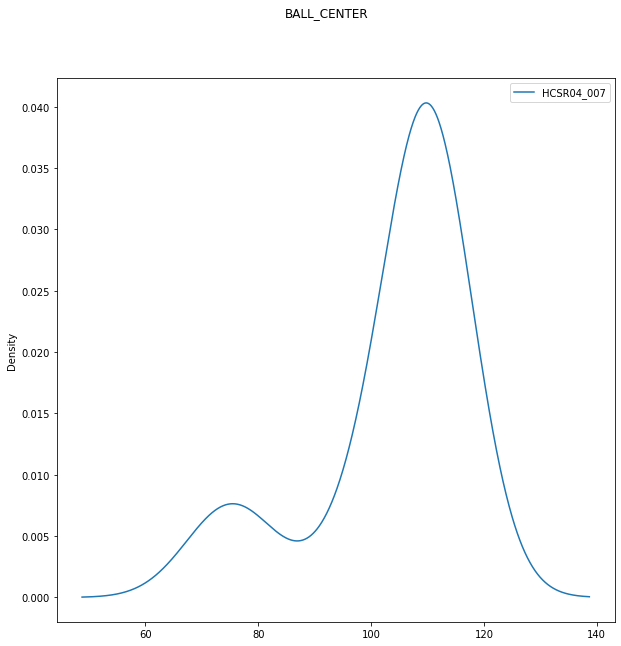

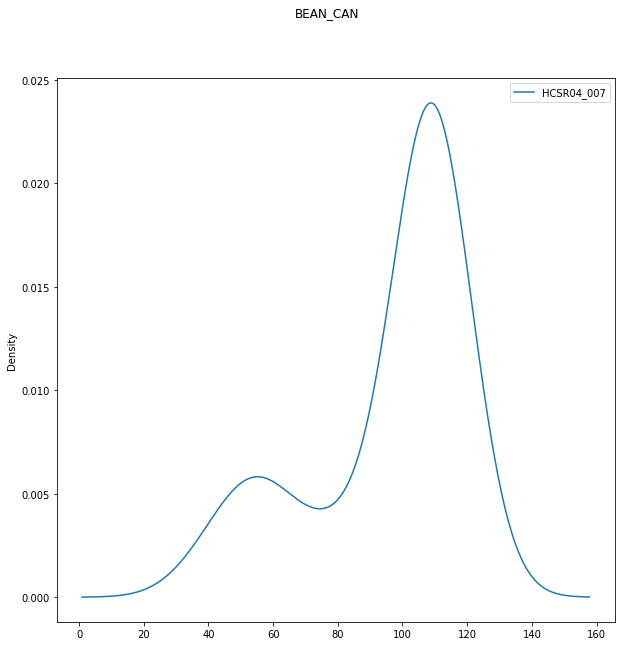

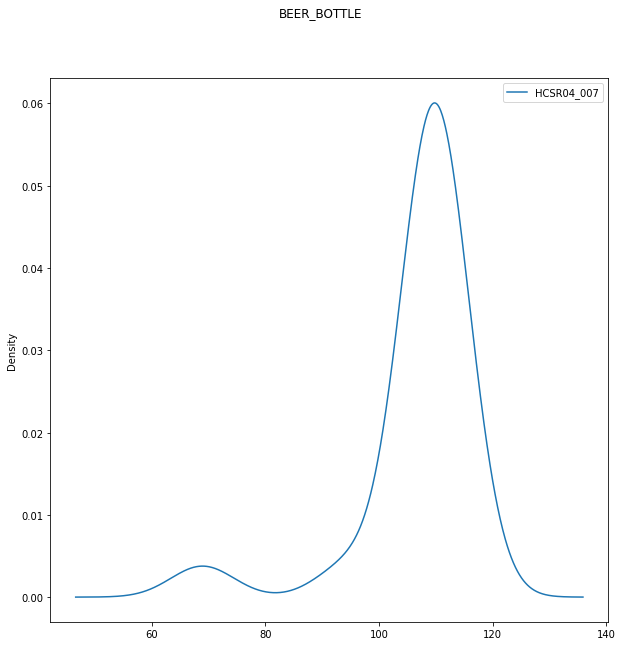

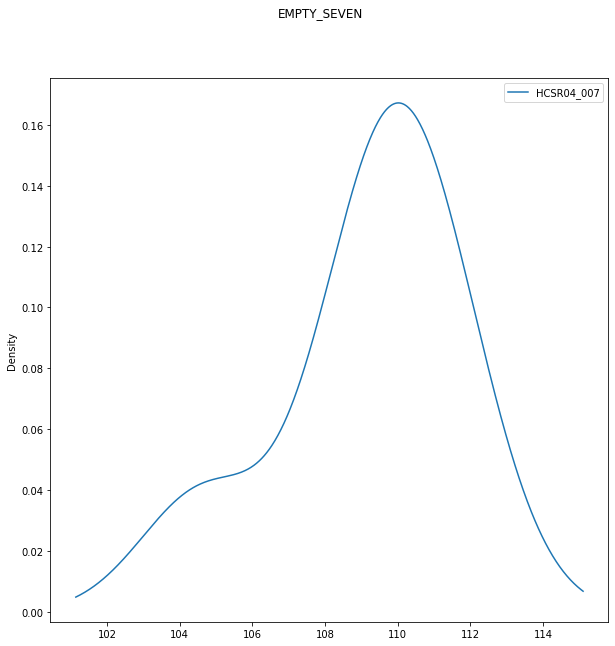

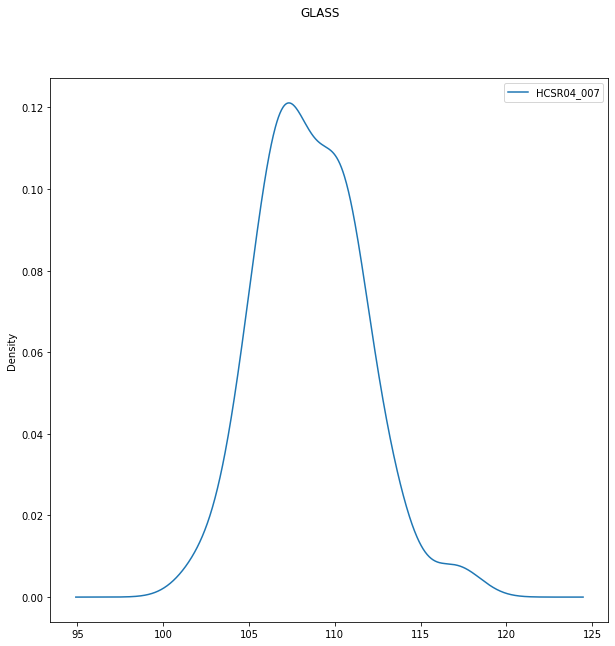

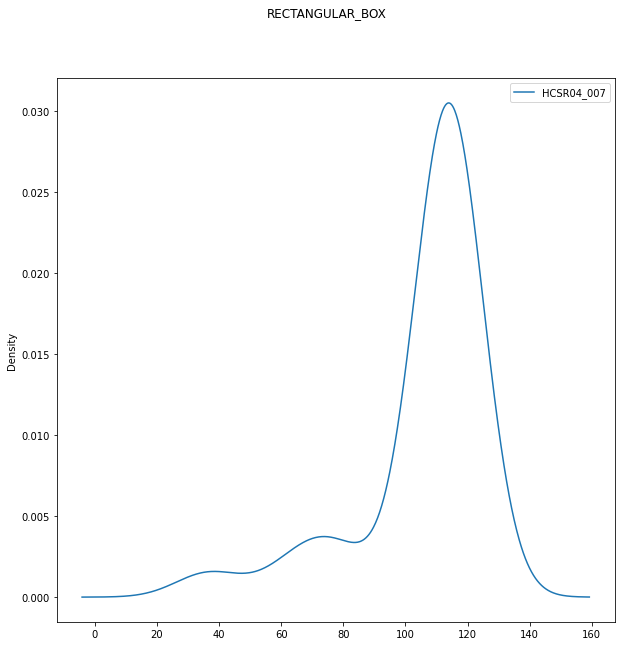

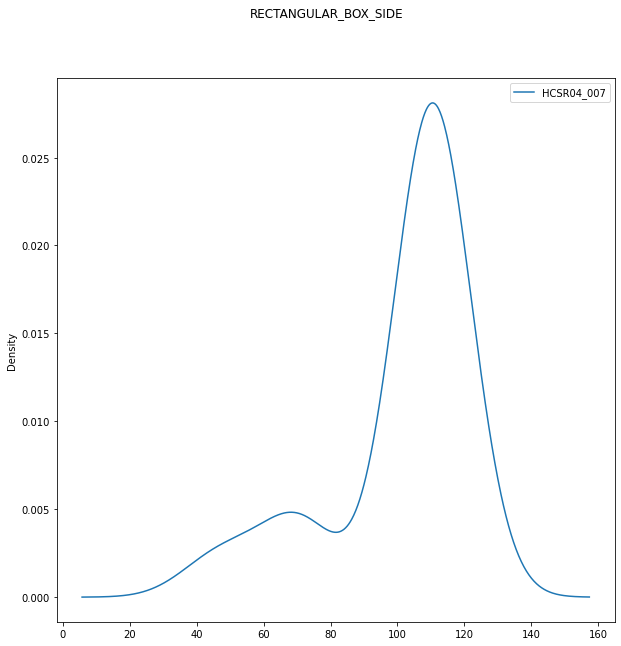

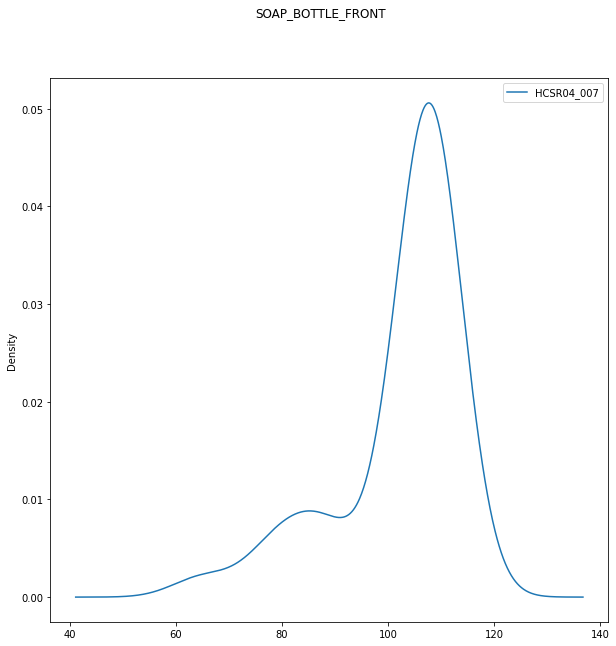

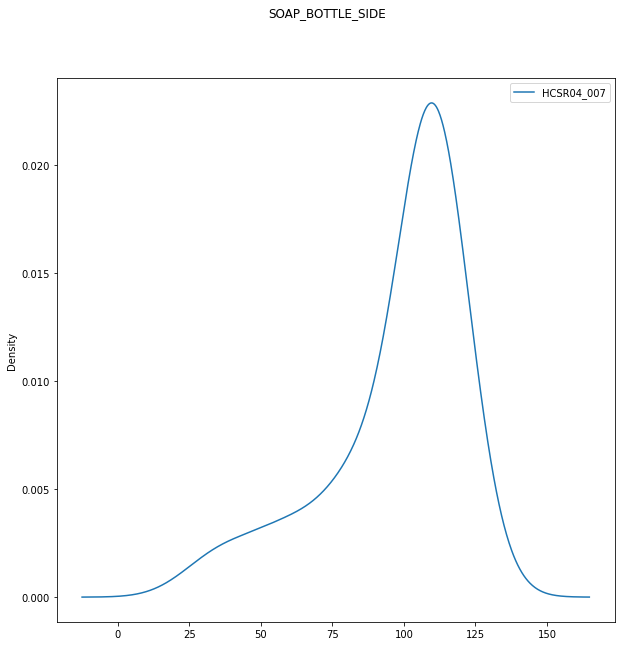

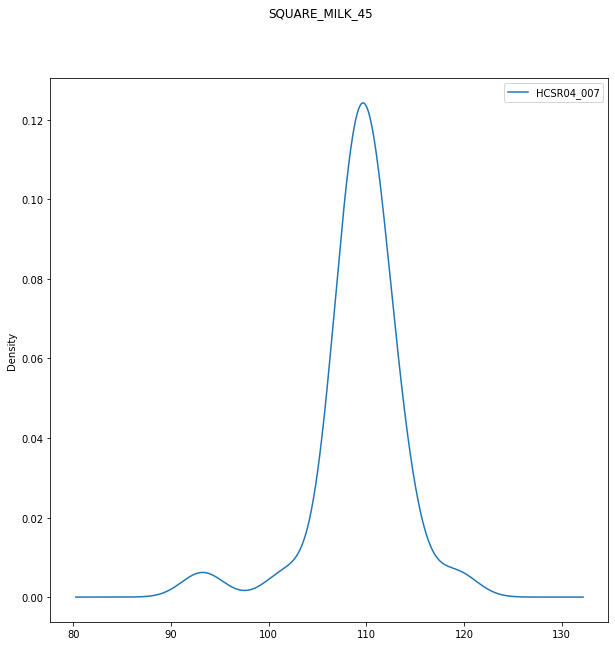

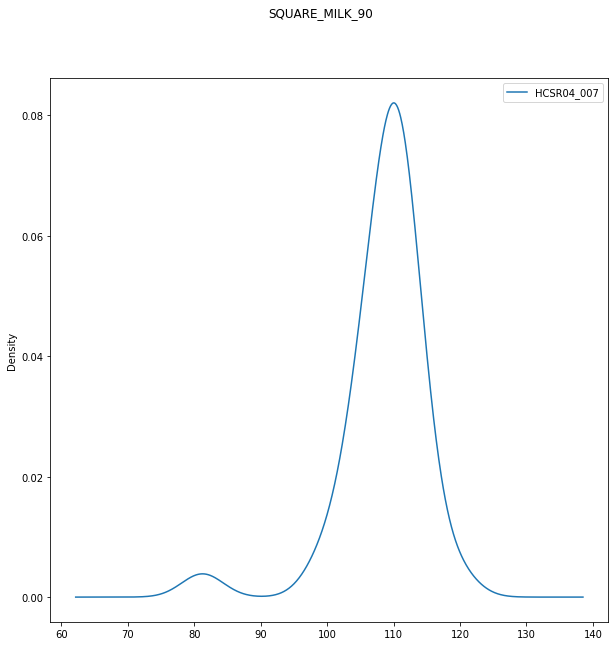

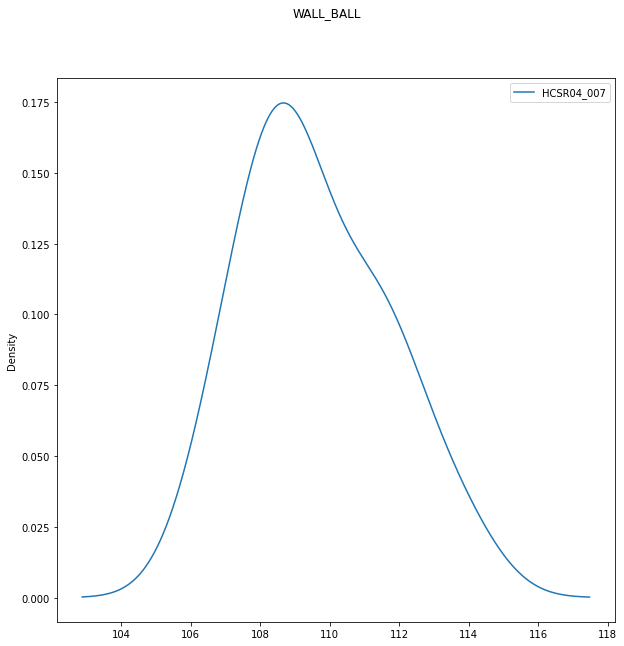

In [160]:
data_HCSR04_007 = data.loc[:,['HCSR04_007','ObjectClass']]

for name, group in data_HCSR04_007.groupby(['ObjectClass']):
    # print the name of the regiment
    group.plot(kind='density', subplots=True, layout=(1,1), sharex=False, figsize=(10,10), title=name)

La distibuzione delle stime fornite da HCSR04_007 nei vari esperimenti è diversa. Sembra quindi ragionevole ipotizzare che, anche se le distanze stimate sono fortemente errate, questi dati  potrebbero quindi contenere informazione utile alla classificazione degli oggetti. Questa ipotesi sarà poi verificata sul campo.

## Analisi dati HCSR-04_006

    HCSR04_006  ObjectClass
0        57.48  BALL_CENTER
1        57.42  BALL_CENTER
2        58.30  BALL_CENTER
3        58.28  BALL_CENTER
4        57.86  BALL_CENTER
5        57.44  BALL_CENTER
6        58.77  BALL_CENTER
7        57.43  BALL_CENTER
8        57.84  BALL_CENTER
9        54.02  BALL_CENTER
10       54.45  BALL_CENTER
11       54.91  BALL_CENTER
12       54.01  BALL_CENTER
13       54.45  BALL_CENTER
14       54.68  BALL_CENTER
15       54.43  BALL_CENTER
16       54.89  BALL_CENTER
17       54.04  BALL_CENTER
18       54.28  BALL_CENTER
19       54.86  BALL_CENTER
    HCSR04_006 ObjectClass
20     2115.51    BEAN_CAN
21     2114.53    BEAN_CAN
22     2114.58    BEAN_CAN
23     2114.95    BEAN_CAN
24     2114.89    BEAN_CAN
25     2114.74    BEAN_CAN
26     2115.73    BEAN_CAN
27     2115.19    BEAN_CAN
28     2115.16    BEAN_CAN
29     2115.65    BEAN_CAN
30     2115.82    BEAN_CAN
31     2115.00    BEAN_CAN
32     2114.92    BEAN_CAN
33     2114.63    BEAN_CAN
34     

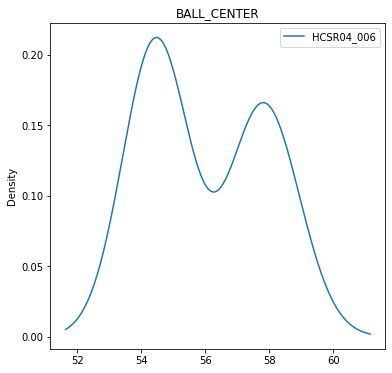

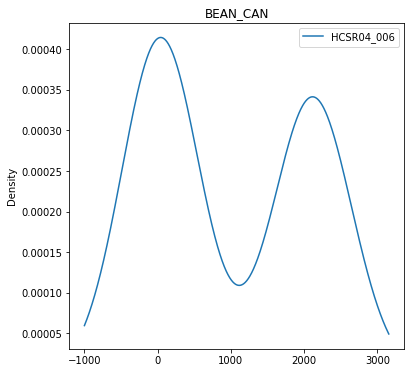

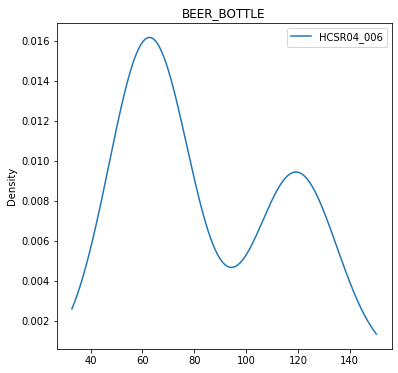

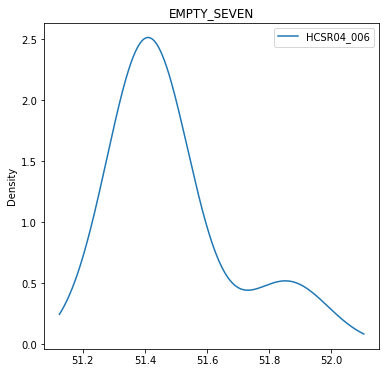

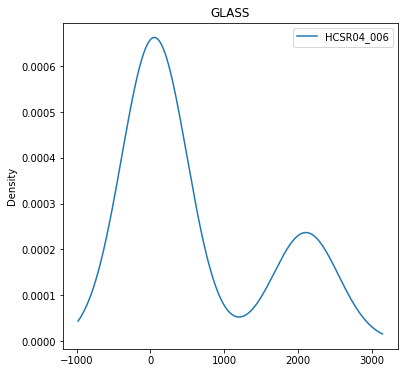

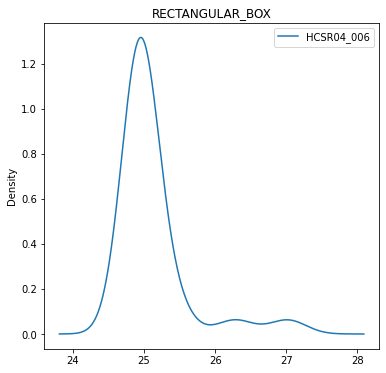

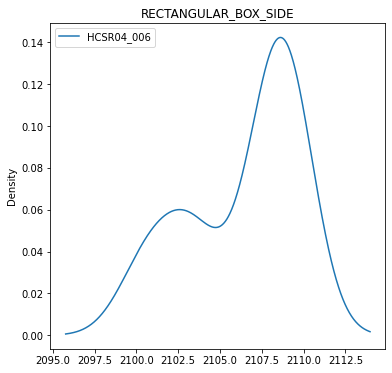

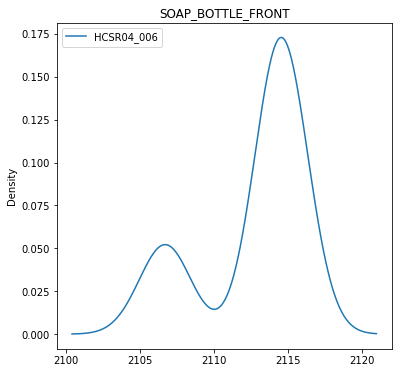

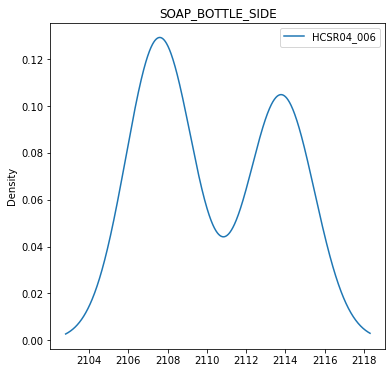

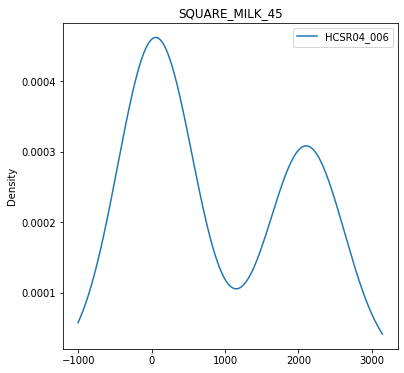

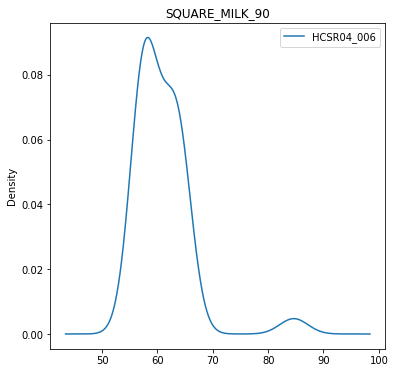

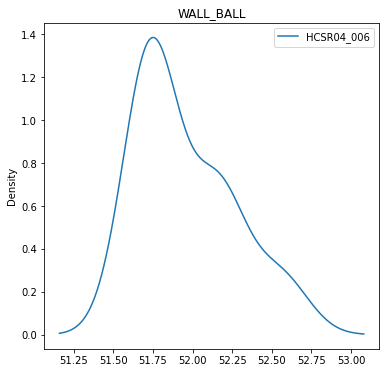

In [161]:
data_HCSR04_006 = data.loc[:,['HCSR04_006','ObjectClass']]

for name, group in data_HCSR04_006.groupby(['ObjectClass']):
    # print the name of the regiment
    group.plot(kind='density', layout=(1,1), sharex=False, figsize=(6,6), title=name)
    print(group)

Un numero significativo di stime fornite da HCSR04_006 sono intorno al valore 2000 cm. Si tratta di misure ottenute quando il bersaglio non occupava completamente l'area di rilevamento del sensore.
Forse le misure defivano da fenomeni di diffrazzione sui bordi o da echi che hganno raggiunto il ricevitore dopo riflessioni multiple.

Non è stato possibile determinare con sicurezza il grado di riproducibilità di queste misure che sembrano dipendere fortemente dalla posizione del bersaglio rispetto al sensore.

Una percentuale significativa delle distanze si trova in un intorno di 2000 nel caso di alcuni esperimenti questo il valore atteso della distribuzione è vicino a 2000. Non è quindi ragionevole consederare questi dati come outlier.

## Dataset di training

Sono stati preparati due distinti dataset di training: 
- dataset completo 
- senza dati HCSR-04_007

I due dataset saranno utiolizzati per addestrare diversi modelli con lo scopo di verificare sperimentalmente quale modello ha le migliori prestazioni in condizioni operative realistiche

In [162]:
x_train_all = data[['HCSR04_001','HCSR04_002','HCSR04_003','HCSR04_004','HCSR04_005','HCSR04_006','HCSR04_007']]
y_train = data[['ObjectClass']]

In [163]:
x_train_NO_007 = data[['HCSR04_001','HCSR04_002','HCSR04_003','HCSR04_004','HCSR04_005','HCSR04_006']]
y_train_NO_007 = data[['ObjectClass']]

In [164]:
x_test= [59,87,26,-53,-79]

## Addestramento modello SVM


### Modello addestrato su dataset completo

In [165]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(x_train, np.ravel(y_train))
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

#### Salvataggio Modello addestrato

In [166]:
import pickle
from google.colab import files
filename='svm_classificator_model_pickle_outline_removed.pkl'
pickle.dump(clf, open(filename, 'wb'))
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Test Classificatore

In [167]:
load_lr_model =pickle.load(open(filename, 'rb'))
load_lr_model.predict([x_test])

array(['BEAN_CAN'], dtype=object)

### Modello addestrato senza HCSR04_007

In [168]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(x_train, np.ravel(y_train))

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [169]:
cross_val_score(clf, x_train, np.ravel(y_train), cv=3, scoring="accuracy")

array([0.62135922, 0.78431373, 0.67647059])

#### Salvataggio Modello addestrato

In [170]:
import pickle
from google.colab import files
filename='svm_classificator_model_pickle_outline_removed_NO_007.pkl'
pickle.dump(clf, open(filename, 'wb'))
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Test Classificatore

In [171]:
load_lr_model =pickle.load(open(filename, 'rb'))
load_lr_model.predict([x_test])

array(['BEAN_CAN'], dtype=object)

## Addestramento LinearSVC

reference: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC

In [172]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import numpy as np
clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0))
clf.fit(x_train, np.ravel(y_train))

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearsvc',
                 LinearSVC(C=1.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=0,
                           tol=0.0001, verbose=0))],
         verbose=False)

In [173]:
cross_val_score(clf, x_train, np.ravel(y_train), cv=3, scoring="accuracy")

array([0.62135922, 0.74509804, 0.66666667])

In [174]:
import pickle
from google.colab import files
filename='linearSVC_classificator_model_pickle_outline_removed.pkl'
pickle.dump(clf, open(filename, 'wb'))
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test

In [175]:
load_lr_model =pickle.load(open(filename, 'rb'))
load_lr_model.predict([x_test])

array(['RECTANGULAR_BOX'], dtype=object)

## Addestramento KNN

In [176]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
clf = make_pipeline(StandardScaler(), KNeighborsClassifier())
clf.fit(x_train, np.ravel(y_train))

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

In [177]:
cross_val_score(clf, x_train, np.ravel(y_train), cv=3, scoring="accuracy")

array([0.80582524, 0.8627451 , 0.71568627])

In [178]:
import pickle
from google.colab import files
filename='knn_classificator_model_pickle_outline_removed.pkl'
pickle.dump(clf, open(filename, 'wb'))
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test

In [179]:
load_lr_model =pickle.load(open(filename, 'rb'))
load_lr_model.predict([x_test])

array(['EMPTY_SEVEN'], dtype=object)